### 1. import EVERYTHING

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 

import psycopg2
import random
from matplotlib import pyplot

### 2. useful functions

In [2]:
def RemoveStopWordsTitle(df):
    #removes a list of stop words from the text
    #text must be in the second column
    for i in range(len(df.index)):
        if i%1000 == 0: print i # just to make sure its working
        query = df.iloc[i,1]
        querywords = query.split()
        resultwords = [word for word in querywords if word.lower() not in stopwords]
        df.iloc[i,1] = ' '.join(resultwords)

    
def Stemmer(df):
    #stemmer for all text
    #text must be in the second column
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    for i in range(len(df.index)):
        query = df.iloc[i,1]
        querywords = query.split()
        resultwords = [stemmer.stem(word) for word in querywords]            
        df.iloc[i,1] = ' '.join(resultwords)

        
def statusUpdate(df):
    if df['status'] == 5: 
        return 1
    else: 
        return 0

In [9]:
conn = psycopg2.connect(database="irs_forecast", user="postgres", password="", host="127.0.0.1", port="5432")

pd.read_sql_query("""select count(*) from ag_topic, article where 
                        intake_date between '6/1/2017' and '6/24/2017' and
                         ag_topic.article_group_id = article.article_group_id and media_type = 1 and
                         status = 5""", con=conn)

,count
0,1523


### 3. read the data

In [129]:
conn = psycopg2.connect(database="irs_forecast", user="postgres", password="", host="127.0.0.1", port="5432")

articles = pd.read_sql_query("""select * from ag_topic, article where 
                        intake_date between '6/16/2017' and '6/24/2017' and
                         ag_topic.article_group_id = article.article_group_id and media_type in (7,8,9) and
                         status not in (5)""", con=conn)

articles_released = pd.read_sql_query("""select * from ag_topic, article where 
                        intake_date between '6/1/2017' and '6/24/2017' and
                         ag_topic.article_group_id = article.article_group_id and media_type in (7,8,9) and
                         status = 5""", con=conn)

articles = articles.append(articles_released)

In [130]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42826 entries, 0 to 5614
Data columns (total 8 columns):
article_group_id    42826 non-null int64
topic_id            42826 non-null int64
status              42826 non-null int64
article_id          42826 non-null int64
article_group_id    42826 non-null int64
intake_date         42826 non-null datetime64[ns]
body                42826 non-null object
media_type          42826 non-null int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 2.9+ MB


### An attempt to reduce 1st past filter problem with a different client's dataset

#### this did not have good results

In [124]:
nwconn = psycopg2.connect(database="client", user="postgres", password="", host="googlecloud.publicrelay.net", port="5432")
sx = pd.read_sql_query("""    
    SELECT 
        article_id, title, body from article, analysis, media, outlet 
    WHERE analysis.client_id = '70273186' and 
        article.article_group_id = analysis.article_group_id and 
        article.outlet_id = outlet.outlet_id and 
        outlet.media_id = media.media_id and
        is_primary and media_type = 'Social Media' and
        intake_date between '3/1/2017' and '6/1/2017'""", con=nwconn)


sx['text'] = sx.title + sx.body
sx = sx.drop(['title','body','article_id'],1)
sx

sx['status'] = 1
cols = ['status','text']
sx[cols]

,status,text
0,1,The fact I just waited 25 minutes on hold with...
1,1,On hold for an IRS representative is totally h...
2,1,Currently on hold with the IRS. How's your mor...
3,1,I just called the IRS and a) it took 15 minute...
4,1,Just got an IRS Scam Call from 877-235-7697 B...
5,1,"IRS scam phone calls going out, beware. @Polit..."
6,1,YOU GUYS PLEASE WATCH OUT FOR FAKE SCAM PHONE ...
7,1,Just got a scam call saying they were the IRS ...
8,1,@Kenn_0703 also i got a FAKE threatening phone...
9,1,"HEY GUYS, I FINALLY GOT AN IRS SCAM CALL!!!1! ..."


In [131]:
articles = articles.drop(['index'],1)
articles = articles.drop_duplicates('article_id', keep='first')
articles = articles.drop(['article_group_id','topic_id','article_id','intake_date'],1)


    
articles['status'] = articles.apply(lambda articles: statusUpdate(articles), axis=1)
articles = articles.rename(index=str, columns={"body": "text"})
articles = articles[articles['media_type'] != 1]
articles = articles.drop(['media_type'], 1)
articles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11699 entries, 0 to 5612
Data columns (total 2 columns):
status    11699 non-null int64
text      11699 non-null object
dtypes: int64(1), object(1)
memory usage: 274.2+ KB


In [132]:
#articles = articles.append(sx)
articles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11699 entries, 0 to 5612
Data columns (total 2 columns):
status    11699 non-null int64
text      11699 non-null object
dtypes: int64(1), object(1)
memory usage: 274.2+ KB


In [133]:
articles = articles.sample(frac=1).reset_index(drop=True)

### Remove funky characters since we're not using a stemmer

In [135]:
RemoveStopWordsTitle(articles)
articles['text'] = articles['text'].str.replace('\n', '')
articles['text'] = articles['text'].str.replace(',', '')
articles['text'] = articles['text'].str.replace('.', '')
articles['text'] = articles['text'].str.replace('"', '')
articles['text'] = articles['text'].str.replace('-', '')
articles['text'] = articles['text'].str.replace(':', '')

%time articles['text'] = articles["text"].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
CPU times: user 983 ms, sys: 7.63 ms, total: 991 ms
Wall time: 996 ms


In [134]:
articles.groupby('status').describe()

text                                                               
        count unique                                                top freq
status                                                                      
0       10117   8957  Hobby or Business? - Did You Know?\n\nLast wee...  208
1        1582   1568  Me: on hold w/IRS.\nMessage: Our representativ...    2

In [136]:
articles = articles[articles.text.str.contains('Terms established provider content') == False]

### Find length of articles and see if there is a difference between released vs unreleased

In [137]:
articles['length'] = articles['text'].map(lambda text: len(text))

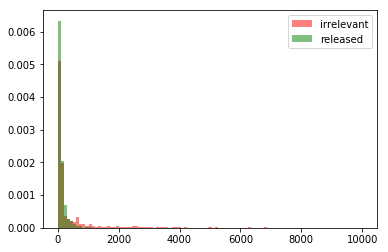

In [138]:
x = articles[articles['status']==1]['length']
y = articles[articles['status']==0]['length']

bins = np.linspace(0, 10000, 100)

pyplot.hist(y, bins, alpha=0.5, label='irrelevant', normed=True, color='red')
pyplot.hist(x, bins, alpha=0.5, label='released', normed=True, color='green')

pyplot.legend(loc='upper right')
pyplot.show()

In [139]:
a = articles[articles['length'] < 10000]
print a[a['status'] == 1].describe()
print
print a[a['status'] == 0].describe()

def split_into_tokens(article):
    article = unicode(article, 'utf8')  # convert bytes into proper unicode
    return TextBlob(article).words

articles.text.head().apply(split_into_tokens)

def split_into_lemmas(article):
    article = unicode(article, 'utf8').lower()
    words = TextBlob(article).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

articles.text.head().apply(split_into_lemmas)

       status       length
count  1582.0  1582.000000
mean      1.0   130.702908
std       0.0   159.870181
min       1.0    11.000000
25%       1.0    55.000000
50%       1.0    81.000000
75%       1.0   133.000000
max       1.0  2160.000000

        status        length
count  10053.0  10053.000000
mean       0.0    475.398289
std        0.0   1064.406599
min        0.0      3.000000
25%        0.0     68.000000
50%        0.0    100.000000
75%        0.0    289.000000
max        0.0   9918.000000


0    [oai10, vision, petrknoth, coar_ev, allow, fun...
1    [kcherrick, mkhammer, usidiocracy2016, factor,...
2              [hoptinger, suck, hate, clientele, irs]
3    [sync, youth, center, community, spavinaw, rig...
4                                                [irs]
Name: text, dtype: object

In [ ]:
"""
%time bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(articles['text'])
print len(bow_transformer.vocabulary_)

%time articles_bow = bow_transformer.transform(articles['text'])
print 'sparse matrix shape:', articles_bow.shape
print 'number of non-zeros:', articles_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * articles_bow.nnz / (articles_bow.shape[0] * articles_bow.shape[1]))
"""

In [60]:
articles

,status,text,length
7173,1,,0
9331,0,...,931
9748,0,...,918
8338,0,Introdu...,2955
5904,0,Advertisement Boeing C...,1765
8445,0,Advertisement Boeing C...,1730
2991,0,Advertisement Lockheed...,2095
5807,0,Advertisement Lockheed...,1996
4272,0,Advertisement market c...,3278
8037,0,Mashable 201...,1897


### split into training and test sets

In [140]:
articles = articles.sort_values(['text'])
msg_train, msg_test, label_train, label_test = \
    train_test_split(articles['text'], articles['status'], test_size=0.2)

print len(msg_train), len(msg_test), len(msg_train) + len(msg_test)

9359 2340 11699


### CV plotting function

In [141]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Define the pipeline of transformations

In [149]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC(kernel='rbf', C=1000.0, gamma=0.001, probability=True, class_weight='balanced')),
])



# pipeline parameters to automatically explore and tune

# after doing the grid search commennt out lines 3 and 4 and rerun it so it only focuses on the best 
# parameters which in this case were C = 1000; gamma = 0.001, kernel = rbf
# you can see how svm_detector.cv_results_ ranks each option below 
param_svm = [
    {'classifier__C': [1000], 'classifier__gamma': [0.001], 'classifier__kernel': ['rbf']}
  #{'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  #{'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']}
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=3),  # what type of cross validation to use
)

### Run it.

In [143]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm

CPU times: user 39 s, sys: 1.04 s, total: 40 s
Wall time: 9min 41s


In [144]:
svm_detector.cv_results_

{'mean_fit_time': array([  45.61837832,   42.93984032,   44.19262004,   48.01319599,
         115.23310828,  112.92355863,   96.83623362,  112.02390862,
          57.64103866,   86.75736602,   44.93968638,   55.09460004]),
 'mean_score_time': array([ 14.07238396,  14.31114769,  13.73332365,  12.88847136,
         18.40715233,  20.75277774,  19.02344751,  16.57179046,
         13.93381802,  14.1977427 ,  12.04571239,  10.07976635]),
 'mean_test_score': array([ 0.92830431,  0.92338925,  0.91227695,  0.90917833,  0.37824554,
         0.37824554,  0.91601667,  0.37824554,  0.92253446,  0.91612352,
         0.93097553,  0.92253446]),
 'mean_train_score': array([ 0.97286036,  0.99545891,  0.99919865,  0.99935891,  0.37832638,
         0.37832638,  0.91916861,  0.37832638,  0.94967411,  0.91916861,
         0.98317134,  0.94967411]),
 'param_classifier__C': masked_array(data = [1 10 100 1000 1 1 10 10 100 100 1000 1000],
              mask = [False False False False False False False False Fa

In [147]:
%time print confusion_matrix(label_test, svm_detector.predict(msg_test))
%time print classification_report(label_test, svm_detector.predict(msg_test))

print confusion_matrix(label_train, svm_detector.predict(msg_train))
print classification_report(label_train, svm_detector.predict(msg_train))

[[1933   88]
 [  57  262]]
CPU times: user 4.18 s, sys: 60.3 ms, total: 4.24 s
Wall time: 4.27 s
             precision    recall  f1-score   support

          0       0.97      0.96      0.96      2021
          1       0.75      0.82      0.78       319

avg / total       0.94      0.94      0.94      2340

CPU times: user 4 s, sys: 54.2 ms, total: 4.06 s
Wall time: 4.06 s
[[7909  187]
 [   2 1261]]
             precision    recall  f1-score   support

          0       1.00      0.98      0.99      8096
          1       0.87      1.00      0.93      1263

avg / total       0.98      0.98      0.98      9359



CPU times: user 1.61 s, sys: 668 ms, total: 2.28 s
Wall time: 5min 39s


<module 'matplotlib.pyplot' from '/Users/elucia/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

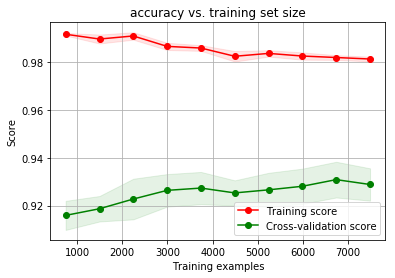

In [150]:
%time plot_learning_curve(pipeline_svm, "accuracy vs. training set size", msg_train, label_train, cv=5, train_sizes=np.linspace(.1, 1.0, 10))

In [151]:
%time p_test = svm_detector.predict_proba(msg_test)
results = []
for i,j,k,m in zip(label_test, msg_test, range(len(label_test)), p_test):
    result = str(i)+":"+str(round(p_test[k][1], 4))+":"+str(j)
    results.append(result)

CPU times: user 3.74 s, sys: 73.9 ms, total: 3.82 s
Wall time: 3.78 s


In [152]:
df_results = pd.DataFrame(results)

df_results['label'] = df_results[0].str.split(":").str.get(0)
df_results['prediction'] = df_results[0].str.split(":").str.get(1)
#df_results['classfication'] = df_results[0].str.split(":").str.get(2)
df_results['text'] = df_results[0].str.split(":").str.get(2)
df_results = df_results.drop([0],1)
df_results.sort_values('prediction', ascending=True)
df = df_results.sort_values('prediction', ascending=False).reset_index()

### convert to float so they can be used as input for histogram

In [153]:
df['label'] = df['label'].map(float)
df['prediction'] = df['prediction'].map(float)

### push results to local

In [156]:
from sqlalchemy import create_engine
engine = create_engine('postgresql+psycopg2://postgres@localhost/irs_forecast')
df_results.to_sql('classification_results2', engine)

### find a decent 'probability score' instead of their default cut off of .4

In [154]:
for i in (0.008, 0.01, 0.025, .05, .1, .15, .2, .25, .3, .35, .4):
    split = i
    print "probability score:         " + str(split)

    test = df[df['label']==1]
    test = test[test['prediction'] < split].reset_index()
    print "postitive articles missed: " + str(len(test))

    test = df[df['label']==0]
    test = test[test['prediction'] > split]
    print "negative articles seen:    " + str(len(test))
    print

probability score:         0.008
postitive articles missed: 0
negative articles seen:    1473

probability score:         0.01
postitive articles missed: 0
negative articles seen:    1331

probability score:         0.025
postitive articles missed: 2
negative articles seen:    827

probability score:         0.05
postitive articles missed: 5
negative articles seen:    425

probability score:         0.1
postitive articles missed: 19
negative articles seen:    248

probability score:         0.15
postitive articles missed: 31
negative articles seen:    184

probability score:         0.2
postitive articles missed: 39
negative articles seen:    141

probability score:         0.25
postitive articles missed: 49
negative articles seen:    109

probability score:         0.3
postitive articles missed: 54
negative articles seen:    91

probability score:         0.35
postitive articles missed: 65
negative articles seen:    85

probability score:         0.4
postitive articles missed: 79
nega

In [33]:
for i in range(len(test)):
    print test['text'][i]
    print "-------------------------------"

KeyError: 0

In [ ]:
#articles.hist(column='length', by='status', bins=50, range=(0,10000))
df.hist(column='prediction', by='label', bins=10)

## plot results

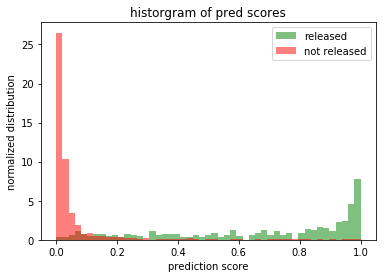

In [155]:
x = df[df['label']==1]['prediction']
y = df[df['label']==0]['prediction']

bins = np.linspace(0, 1, 50)

pyplot.hist(x, bins, alpha=0.5, label='released', normed=True, color='green')
pyplot.hist(y, bins, alpha=0.5, label='not released', normed=True, color='red')
plt.xlabel('prediction score')
plt.ylabel('normalized distribution')
plt.title('historgram of pred scores')
pyplot.legend(loc='upper right')
pyplot.show()

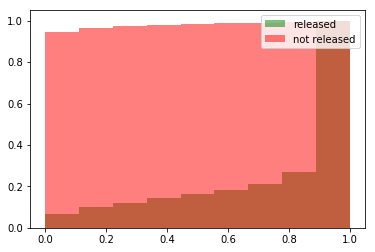

In [38]:
x = df[df['label']==1]['prediction']
y = df[df['label']==0]['prediction']

bins = numpy.linspace(0, 1, 10)

pyplot.hist(x, bins, alpha=0.5, label='released', normed=True, color='green', cumulative=True)
pyplot.hist(y, bins, alpha=0.5, label='not released', normed=True, color='red', cumulative=True)
pyplot.legend(loc='upper right')
pyplot.show()

In [19]:
#this is my list of stop words. Sorry about the formatting..

stopwords = ['a','able','about','above','abst','accordance','according','accordingly','across','act','actually',
'added','adj','affected','affecting','affects','after','afterwards','again','against','ah','all','almost','alone',
'along','already','also','although','always','am','among','amongst','an','and','announce','another','any','anybody',
'anyhow','anymore','anyone','anything','anyway','anyways','anywhere','apparently','approximately','are','aren',
'arent','arise','around','as','aside','ask','asking','at','auth','available','away','awfully','b','back','be',
'became','because','become','becomes','becoming','been','before','beforehand','begin','beginning','beginnings',
'begins','behind','being','believe','below','beside','besides','between','beyond','biol','both','brief',
'briefly','but','by','c','ca','came','can','cannot',"can't",'cause','causes','certain','certainly','co','com',
'come','comes','contain','containing','contains','could','couldnt','d','date','did',"didn't",'different','do',
'does',"doesn't",'doing','done',"don't",'down','downwards','due','during','e','each','ed','edu','effect','eg','eight',
'eighty','either','else','elsewhere','end','ending','enough','especially','et','et-al','etc','even','ever','every',
'everybody','everyone','everything','everywhere','ex','except','f','far','few','ff','fifth','first','five','fix',
'followed','following','follows','for','former','formerly','forth','found','four','from','further','furthermore',
'g','gave','get','gets','getting','give','given','gives','giving','go','goes','gone','got','gotten','h','had',
'happens','hardly','has',"hasn't",'have',"haven't",'having','he','hed','hence','her','here','hereafter','hereby',
'herein','heres','hereupon','hers','herself','hes','hi','hid','him','himself','his','hither','home','how','howbeit',
'however','hundred','i','id','ie','if',"i'll",'im','immediate','immediately','importance','important','in','inc',
'indeed','index','information','instead','into','invention','inward','is',"isn't",'it','itd',"it'll",'its','itself',
"i've",'j','just','k','keep','keeps','kept','kg','km','know','known','knows','l','largely','last','lately','later',
'latter','latterly','least','less','lest','let','lets','like','liked','likely','line','little',"'ll",'look','looking',
'looks','ltd','m','made','mainly','make','makes','many','may','maybe','me','mean','means','meantime','meanwhile',
'merely','mg','might','million','miss','ml','more','moreover','most','mostly','mr','mrs','much','mug','must','my',
'myself','n','na','name','namely','nay','nd','near','nearly','necessarily','necessary','need','needs','neither',
'never','nevertheless','new','next','nine','ninety','no','nobody','non','none','nonetheless','noone','nor',
'normally','nos','not','noted','nothing','now','nowhere','o','obtain','obtained','obviously','of','off','often',
'oh','ok','okay','old','omitted','on','once','one','ones','only','onto','or','ord','other','others','otherwise',
'ought','our','ours','ourselves','out','outside','over','overall','owing','own','p','page','pages','part','particular',
'particularly','past','per','perhaps','placed','please','plus','poorly','possible','possibly','potentially',
'pp','predominantly','present','previously','primarily','probably','promptly','proud','provides','put','q',
'que','quickly','quite','qv','r','ran','rather','rd','re','readily','really','recent','recently','ref',
'refs','regarding','regardless','regards','related','relatively','research','respectively','resulted','resulting',
'results','right','run','s','said','same','saw','say','saying','says','sec','section','see','seeing','seem',
'seemed','seeming','seems','seen','self','selves','sent','seven','several','shall','she','shed',"she'll",
'shes','should',"shouldn't",'show','showed','shown','showns','shows','significant','significantly','similar',
'similarly','since','six','slightly','so','some','somebody','somehow','someone','somethan','something','sometime',
'sometimes','somewhat','somewhere','soon','sorry','specifically','specified','specify','specifying','still',
'stop','strongly','sub','substantially','successfully','such','sufficiently','suggest','sup','sure','t','take',
'taken','taking','tell','tends','th','than','thank','thanks','thanx','that',"that'll",'thats',"that've",
'the','their','theirs','them','themselves','then','thence','there','thereafter','thereby','thered','therefore',
'therein',"there'll",'thereof','therere','theres','thereto','thereupon',"there've",'these','they','theyd',"they'll",
'theyre',"they've",'think','this','those','thou','though','thoughh','thousand','throug','through','throughout','thru',
'thus','til','tip','to','together','too','took','toward','towards','tried','tries','truly','try','trying','ts',
'twice','two','u','un','under','unfortunately','unless','unlike','unlikely','until','unto','up','upon','ups','us',
'use','used','useful','usefully','usefulness','uses','using','usually','v','value','various',"'ve",'very','via',
'viz','vol','vols','vs','w','want','wants','was','wasnt','way','we','wed','welcome',"we'll",'went','were','werent',
"we've",'what','whatever',"what'll",'whats','when','whence','whenever','where','whereafter','whereas','whereby',
'wherein','wheres','whereupon','wherever','whether','which','while','whim','whither','who','whod','whoever',
'whole',"who'll",'whom','whomever','whos','whose','why','widely','willing','wish','with','within','without',
'wont','words','world','would','wouldnt','www','x','y','yes','yet','you','youd',"you'll",'your','youre','yours',
'yourself','yourselves',"you've",'z','zero']